<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/decomposition_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import seaborn as sns

import sys
sys.path.append('../')

# Filtra todos os avisos do LightGBM
warnings.filterwarnings("ignore", category=UserWarning, message=".*lightgbm.*")

# Tratamento Inicial do DataFrame

In [33]:
with open('database/df.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,item_nbr,year,month,onpromotion,unit_sales,year_month,family,class,perishable,oil_price
0,103520,2013,1,True,201.00,2013-01,GROCERY I,1028,False,94.76
1,103520,2013,2,True,179.00,2013-02,GROCERY I,1028,False,95.31
2,103520,2013,3,True,296.00,2013-03,GROCERY I,1028,False,92.94
3,103520,2013,4,True,212.00,2013-04,GROCERY I,1028,False,92.02
4,103520,2013,5,True,172.00,2013-05,GROCERY I,1028,False,94.51


In [34]:
df = df[df['unit_sales'] >= 0]
df.rename(columns={'year_month': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()
df = df.loc['2013-01-01':'2016-12-31']

In [35]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]

In [97]:
df_agg = df.groupby('date')['unit_sales'].sum()

# Análise Exploratória

In [12]:
def plot_series(original, trend, seasonal, resid, title=None):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10), layout='constrained')
    original.plot(ax=ax[0])
    ax[0].set_title('Original')
    trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    if title:
        plt.suptitle(title, fontsize=20)

    plt.show()

In [13]:
def decompose_series(series, period=12, plot=False, title=None):
    decomposition = seasonal_decompose(series, period=period)
    if plot:
        if title is not None:
            plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid, title=title)
        else:
            plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid)
    return decomposition

## Analisando as vendas gerais

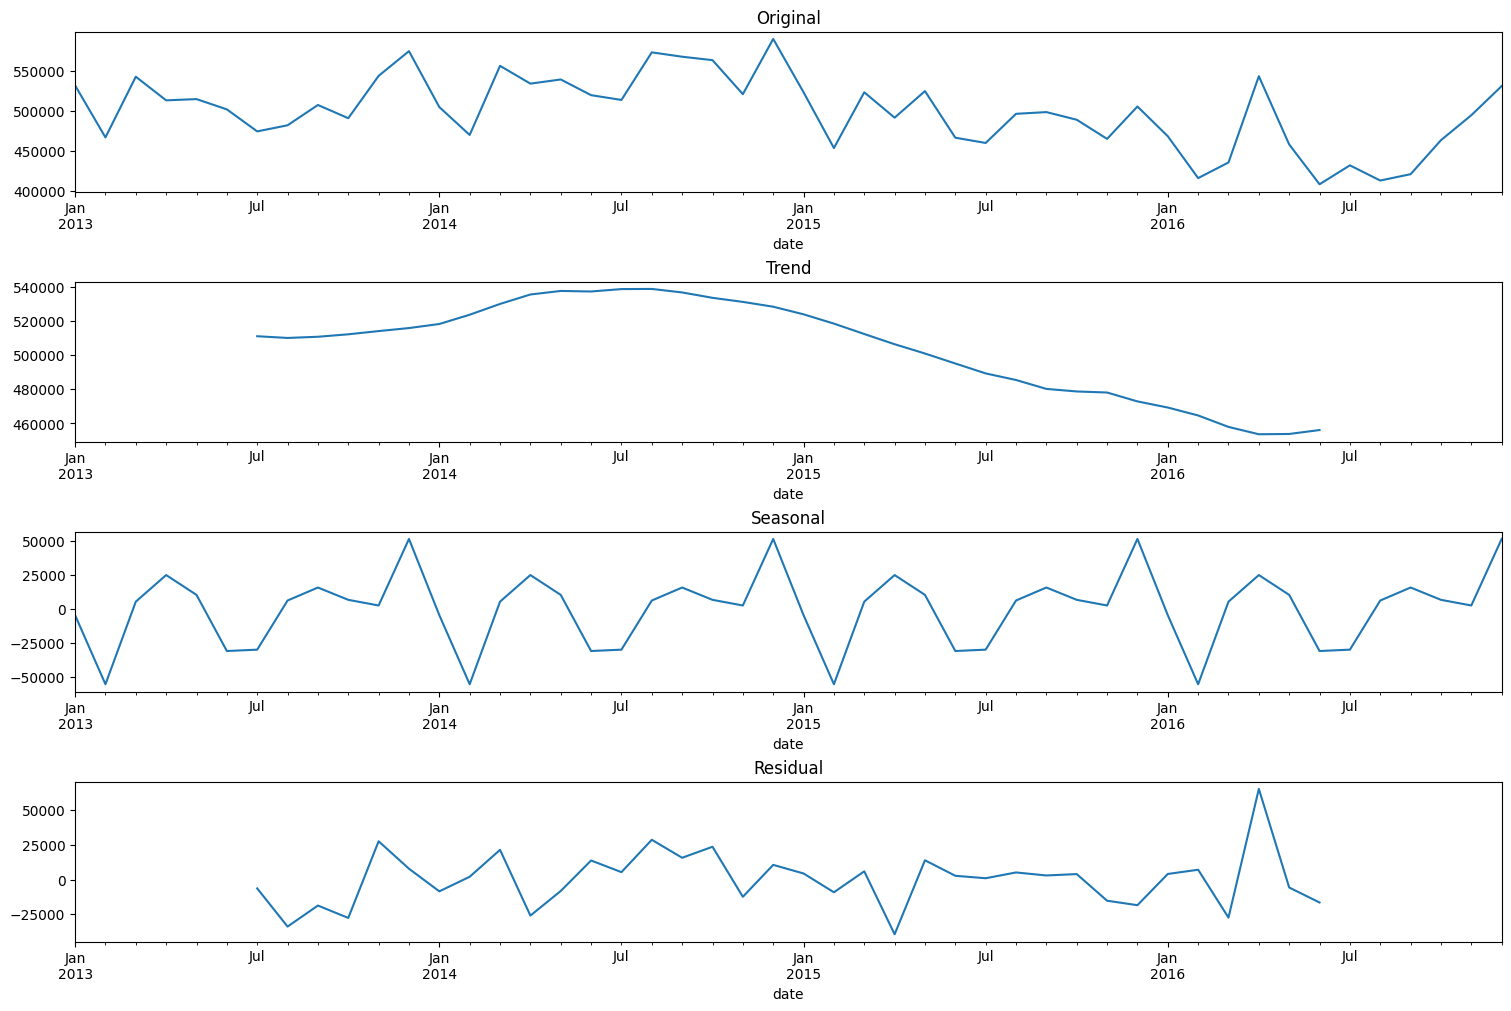

In [14]:
# série temporal da venda de todos os produtos

og_residual = decompose_series(df_agg['unit_sales'], period=12).resid
og_seasonal = decompose_series(df_agg['unit_sales'], period=12).seasonal
decompose_series(df_agg['unit_sales'], period=12, plot=True)

<Axes: >

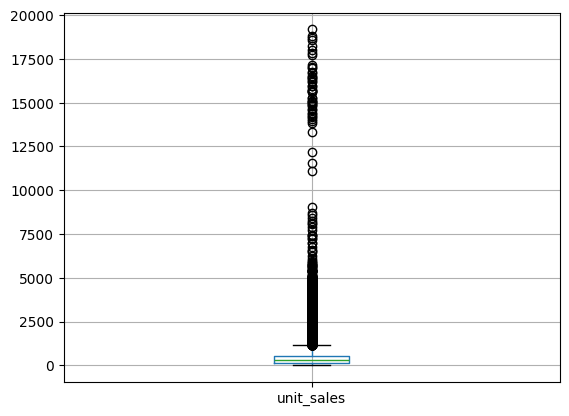

In [15]:
# boxplot to idenfity outliers
df.boxplot(column='unit_sales')

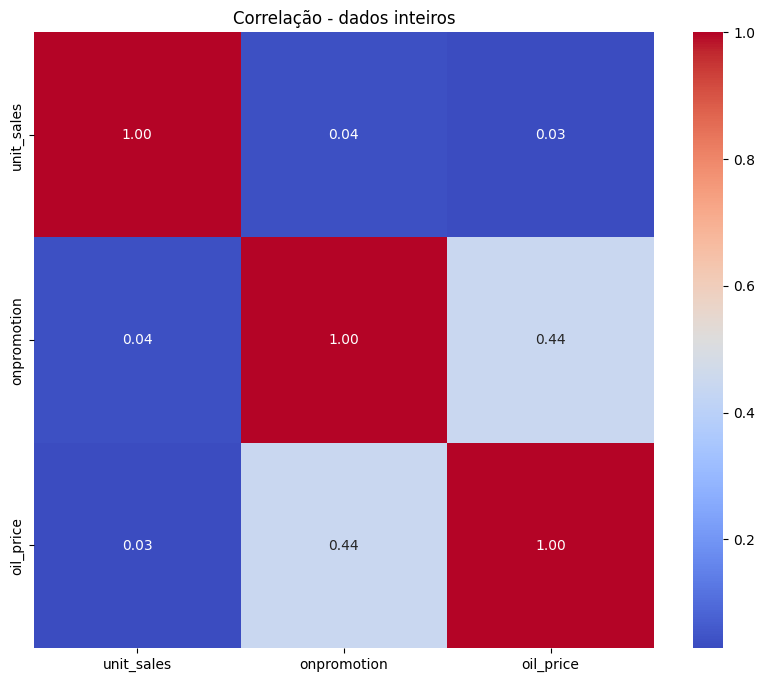

In [16]:
correlations = df[['unit_sales', 'onpromotion', 'oil_price']].corr()

# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - dados inteiros')
plt.show()

## Vendas de uma família de produtos

In [19]:
df_family = df[df['family'] == 'DAIRY']

<Axes: >

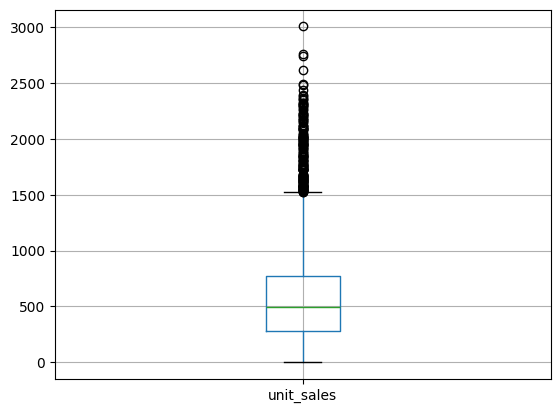

In [20]:
df_family.boxplot(column='unit_sales')

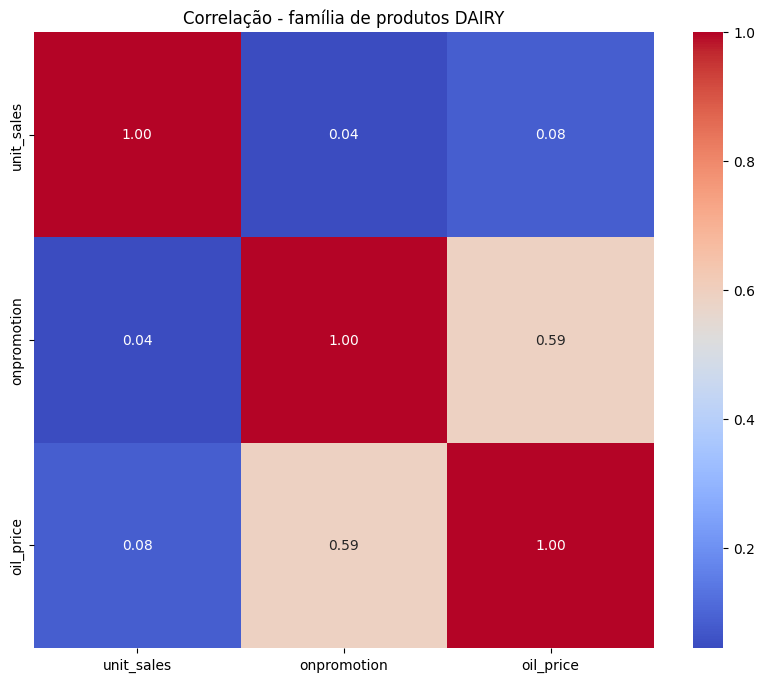

In [21]:
correlations = df_family[['unit_sales', 'onpromotion', 'oil_price']].corr()

# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - família de produtos DAIRY')
plt.show()

## Utilizando o produto 870938

classe: DAIRY  
perishable: True

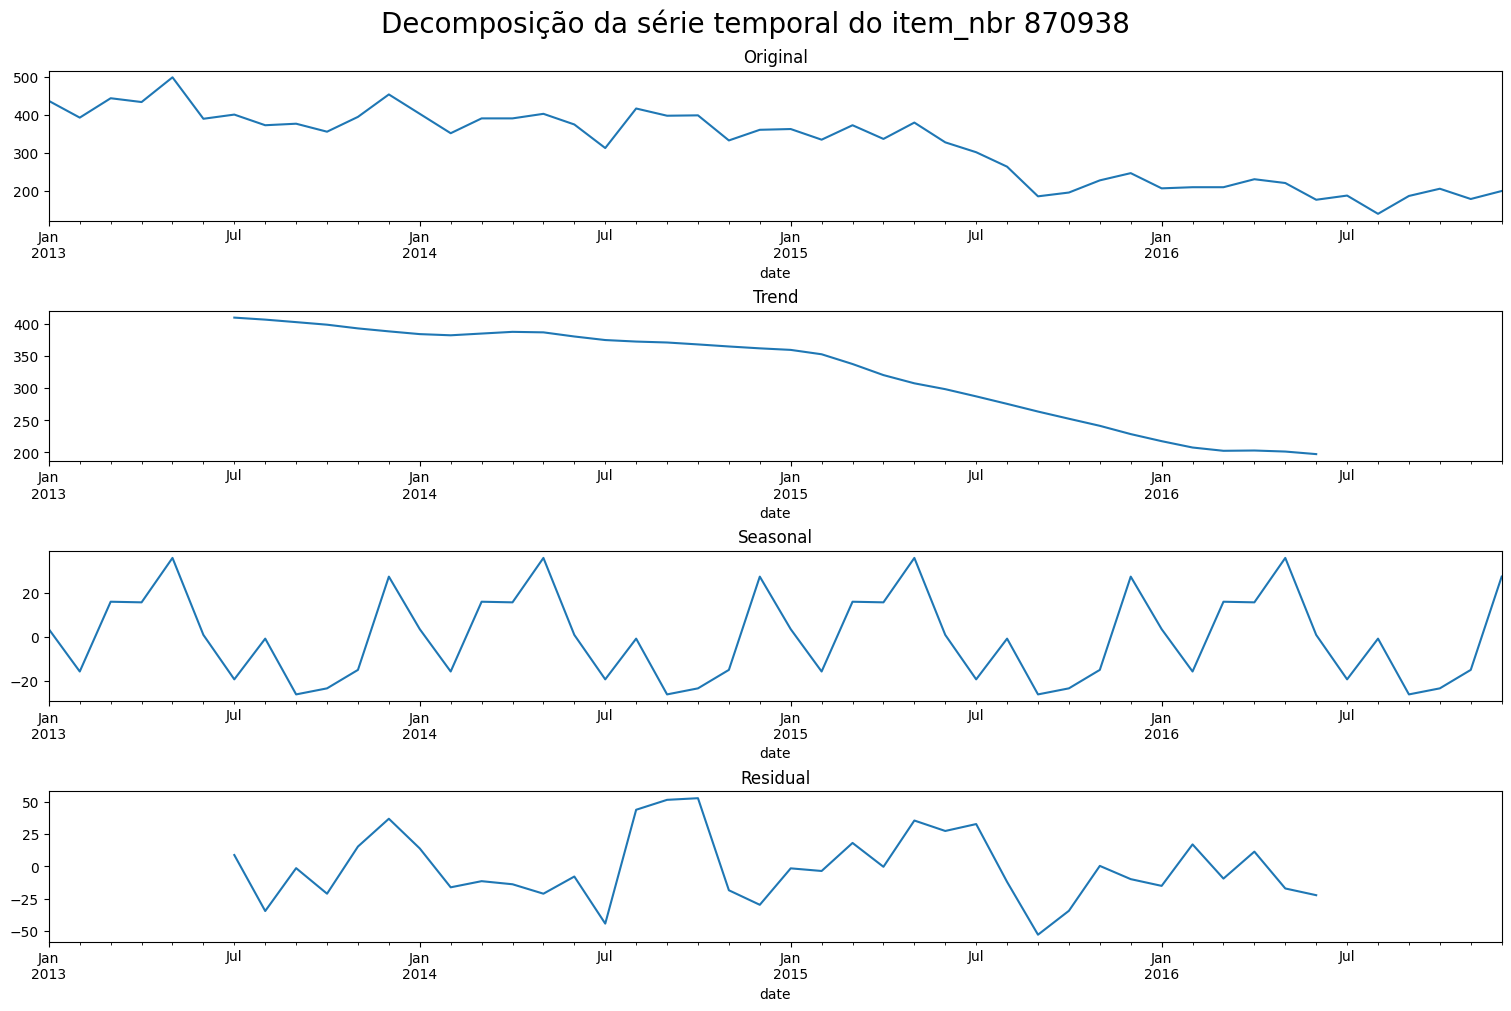

In [22]:
# decompor a série temporal em 3 componentes: tendência, sazonalidade e resíduos
decompose_series(df_item['unit_sales'], period=12, plot=True, title='Decomposição da série temporal do item_nbr 870938')

<Axes: >

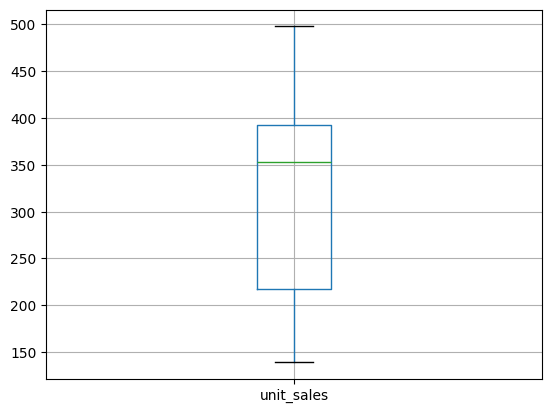

In [23]:
# boxplot to idenfity outliers
df_item.boxplot(column='unit_sales')

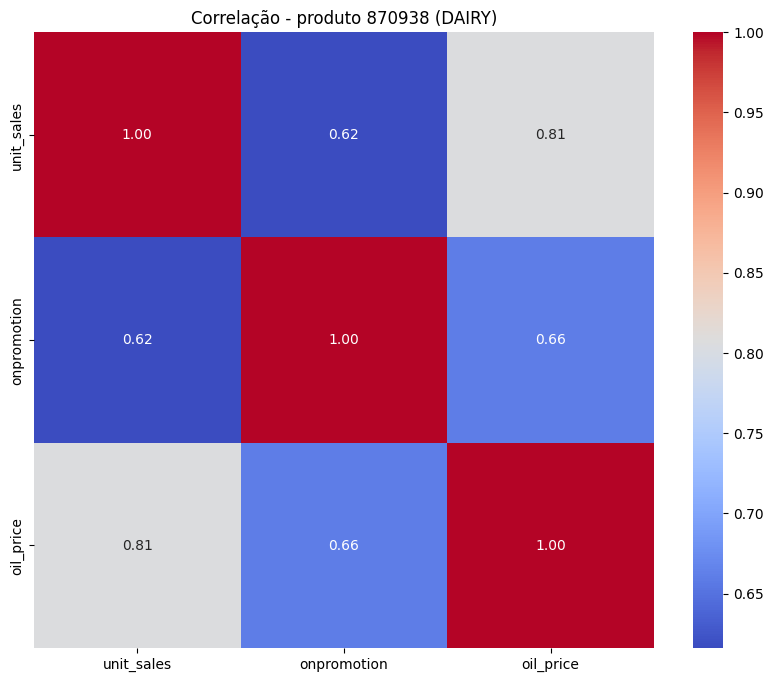

In [38]:
correlations = df_item[['unit_sales', 'onpromotion', 'oil_price']].corr()

# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - produto 870938 (DAIRY)')
plt.show()

Estatística do teste ADF: -0.7873198611497035
Valor-p: 0.8228184161088707
A série temporal não é estacionária
Diferenciando a série temporal...

Estatística do teste ADF: -10.123993172453309
Valor-p: 9.284834317039425e-18
A série temporal é estacionária após a diferenciação


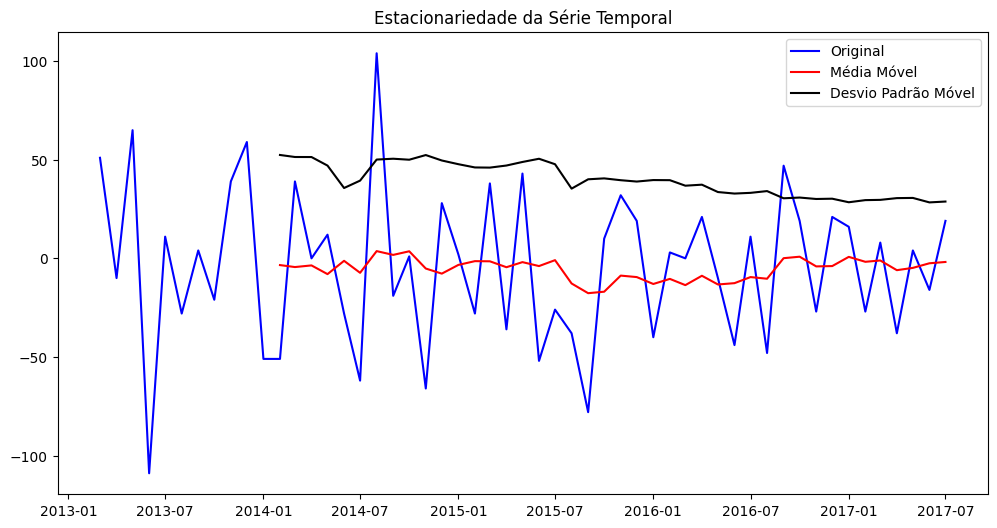

In [54]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]
#df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
df_item.set_index('date', inplace=True)

# Executar o teste de Dickey-Fuller Aumentado
result = adfuller(df_item['unit_sales'].values)

# Resultados do teste
print('Estatística do teste ADF:', result[0])
print('Valor-p:', result[1])

# Interpretação do resultado
if result[1] <= 0.05:
    print("A série temporal é estacionária")
    data_diff = pd.Series(df_item['unit_sales'])
else:
    print("A série temporal não é estacionária")
    print("Diferenciando a série temporal...\n")
    data_diff = pd.Series(df_item['unit_sales']).diff().dropna()
    data_diff = data_diff.iloc[1:]
    result2 = adfuller(data_diff)
    print('Estatística do teste ADF:', result2[0])
    print('Valor-p:', result2[1])
    if result2[1] <= 0.05:
        print("A série temporal é estacionária após a diferenciação")
    else:
        print("A série temporal não é estacionária após a diferenciação")

# plottando
rolmean = data_diff.rolling(window=12).mean()
rolstd = data_diff.rolling(window=12).std()
plt.figure(figsize=(12, 6))
plt.plot(data_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Média Móvel')
plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
plt.legend(loc='best')
plt.title('Estacionariedade da Série Temporal')
plt.show()

# Testando a autocorrelação dos dados

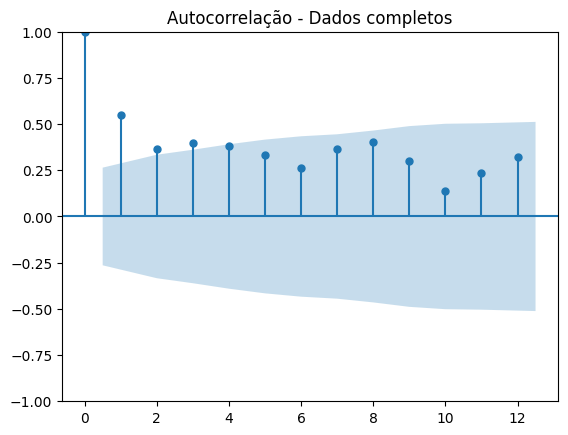

In [64]:
# autocorrelação para os dados completos
sm.graphics.tsa.plot_acf(df_agg['unit_sales'].values, lags=12)
plt.title("Autocorrelação - Dados completos")
plt.show()

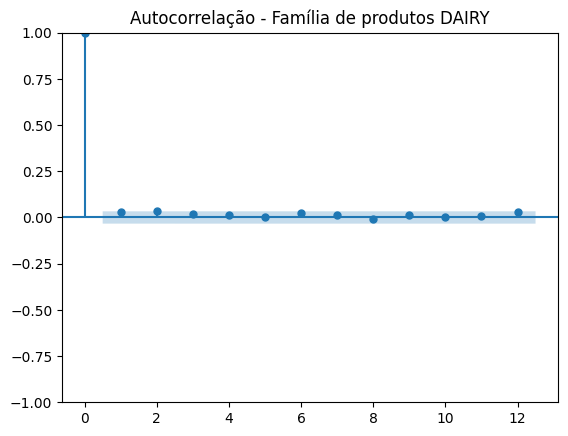

In [39]:
# autocorrelação para a família de produtos DAIRY
sm.graphics.tsa.plot_acf(df_family['unit_sales'].values, lags=12)
plt.title("Autocorrelação - Família de produtos DAIRY")
plt.show()

Text(0.5, 1.0, 'Autocorrelação - Produto 870938')

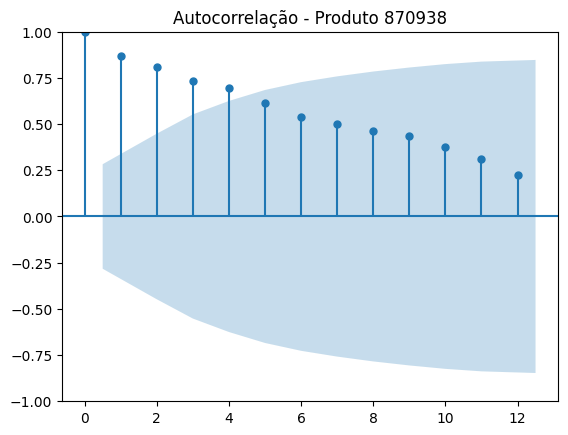

In [40]:
# autocorrelação para o item_nbr 870938
sm.graphics.tsa.plot_acf(df_item['unit_sales'].values, lags=12)
plt.title("Autocorrelação - Produto 870938")

## Teste de hipótese para o produto aleatório escolhido

| O teste de Ljung-Box é usado comumente usado na modelagem  
do modelo ARIMA. Feito para testar autocorrelação dos dados  
podemos passar vários lags para testar qual dará como resultado  
uma correlação, ou não.

In [65]:
# teste
df_item = df[df['item_nbr'] == 870938]

values = df_item['unit_sales'].values

lags = range(1, 13)
# Realiza o teste Ljung-Box
df_test = acorr_ljungbox(values, lags=lags)
stat, p_value = (df_test['lb_stat'], df_test['lb_pvalue'])

for lag, p_val in zip(lags, p_value):
    if p_val < 0.05:
        print(f'Autocorrelação significativa encontrada no lag {lag} com p-valor {p_val}')

Autocorrelação significativa encontrada no lag 1 com p-valor 1.2620914668522595e-11
Autocorrelação significativa encontrada no lag 2 com p-valor 1.2331001206487947e-19
Autocorrelação significativa encontrada no lag 3 com p-valor 2.419561342603751e-26
Autocorrelação significativa encontrada no lag 4 com p-valor 1.7001596289787725e-32
Autocorrelação significativa encontrada no lag 5 com p-valor 9.600329508291425e-38
Autocorrelação significativa encontrada no lag 6 com p-valor 3.3972383471224115e-42
Autocorrelação significativa encontrada no lag 7 com p-valor 1.872246330537621e-46
Autocorrelação significativa encontrada no lag 8 com p-valor 2.2384900133279036e-50
Autocorrelação significativa encontrada no lag 9 com p-valor 7.300225853364852e-54
Autocorrelação significativa encontrada no lag 10 com p-valor 8.5949269733627e-57
Autocorrelação significativa encontrada no lag 11 com p-valor 5.317612940727629e-59
Autocorrelação significativa encontrada no lag 12 com p-valor 2.884653508460305e-6

## Testando o restante dos itens do dataset

Valores da ACF para diferentes lags para o item 220435:
[1.         0.87278051 0.79536452 0.75939821 0.70958166 0.65851438
 0.64276433 0.6476683  0.60246131 0.56350888 0.47701088 0.38330732
 0.33597563]


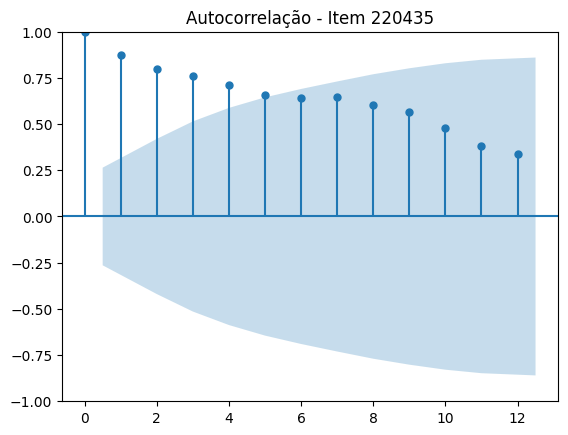

Valores da ACF para diferentes lags para o item 452212:
[1.         0.90353845 0.8704817  0.83009879 0.76578587 0.73083493
 0.69011977 0.61289434 0.56694454 0.50346221 0.43896704 0.36477419
 0.30212175]


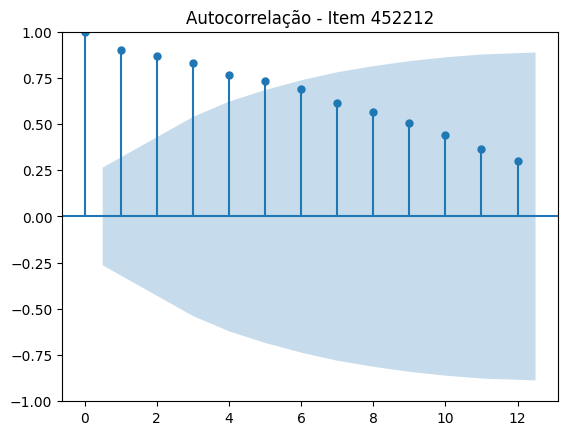

Valores da ACF para diferentes lags para o item 517905:
[1.         0.90258834 0.88759974 0.85006676 0.81146701 0.74455033
 0.70951844 0.62519457 0.6042444  0.53347622 0.46689611 0.39840773
 0.34965338]


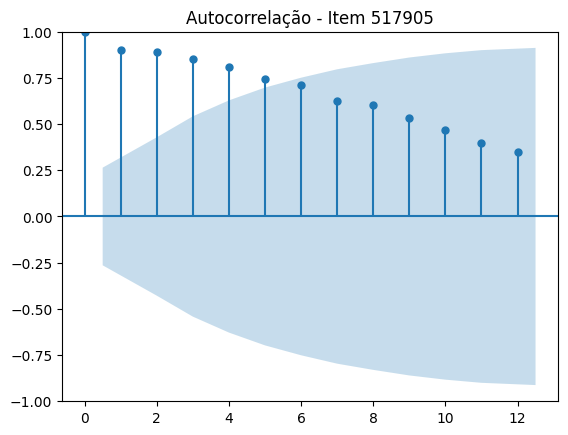

Valores da ACF para diferentes lags para o item 660502:
[1.         0.95554826 0.9102315  0.86603639 0.80715871 0.73424994
 0.66603089 0.60341356 0.52973694 0.45259345 0.37175326 0.29933964
 0.22204938]


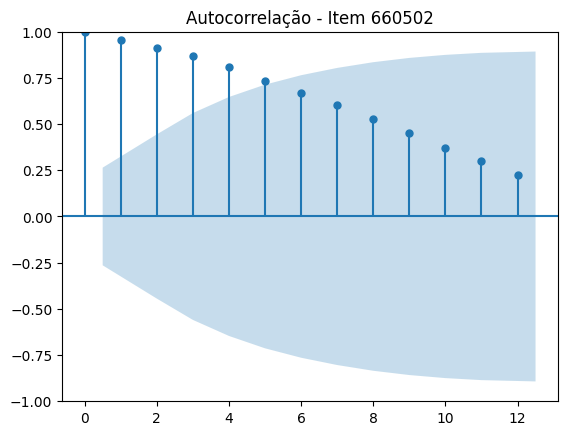

Valores da ACF para diferentes lags para o item 838409:
[1.         0.8751746  0.84299401 0.8080997  0.7711756  0.72371968
 0.6505412  0.61264082 0.54943824 0.4865049  0.43621456 0.37986427
 0.34354956]


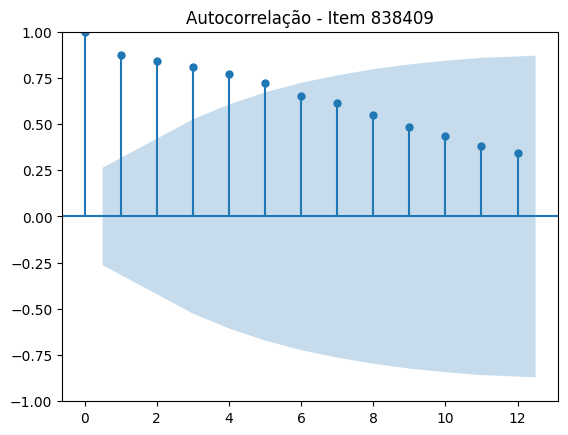

Valores da ACF para diferentes lags para o item 870938:
[1.         0.88890229 0.83464779 0.76475201 0.72926755 0.67375756
 0.62148419 0.60350161 0.57674655 0.54326819 0.50060657 0.44359681
 0.36115956]


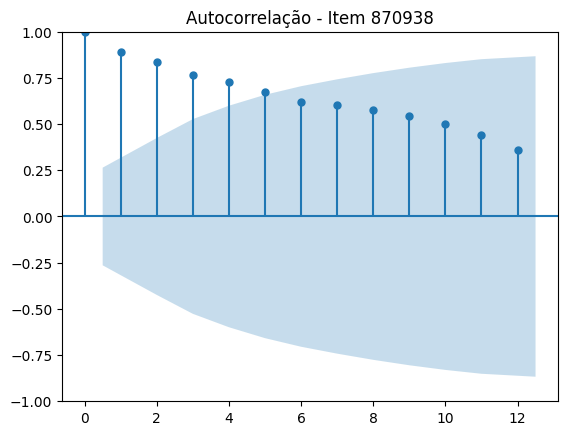

In [67]:
for item in df['item_nbr'].unique():
  df_item = df[df['item_nbr'] == item]
  df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
  df_item.reset_index(drop=True, inplace=True)
  df_item.drop(columns='date', inplace=True)
  acf_values = sm.tsa.acf(df_item, nlags=12)
  acf_mean = acf_values.sum() / 12
  if acf_mean > 0.7:
    print(f"Valores da ACF para diferentes lags para o item {item}:")
    print(acf_values)
    sm.graphics.tsa.plot_acf(df_item, lags=12)
    plt.title(f"Autocorrelação - Item {item}")
    plt.show()

# Avaliando residuais

Pressupostos para previsão

*   Não devem estar autocorrelacionados
*   Média deve ser zero (aproximadamente)
*   Variância constante
*   Distribuição normal

In [46]:
# teste de normalidade
decomposition = seasonal_decompose(df_item['unit_sales'], period=12)
residuos_item = decomposition.resid
print(f'Quantidade de valores nulos: {residuos_item.isna().sum()}') # preencher os valores nulos com a média dos valores não nulos ou droppar

residuos_item.dropna(inplace=True) # decidimos droppar
print(f'Quantidade de valores nulos após a remoção: {residuos_item.isna().sum()}\n')

Quantidade de valores nulos: 12
Quantidade de valores nulos após a remoção: 0



Valores da ACF para diferentes lags:
[ 1.          0.3183614  -0.05244733 -0.3780086  -0.2704148  -0.13365799
 -0.15985855 -0.00764058  0.23178803  0.57561059  0.16855813 -0.1347184
 -0.54141182]


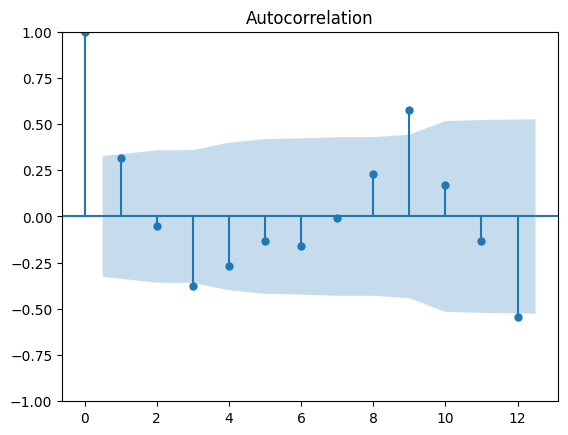

In [48]:
# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(residuos_item.values, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(residuos_item.values, lags=12)
plt.show()

In [71]:
residuos_item.mean()

0.0888310185185383

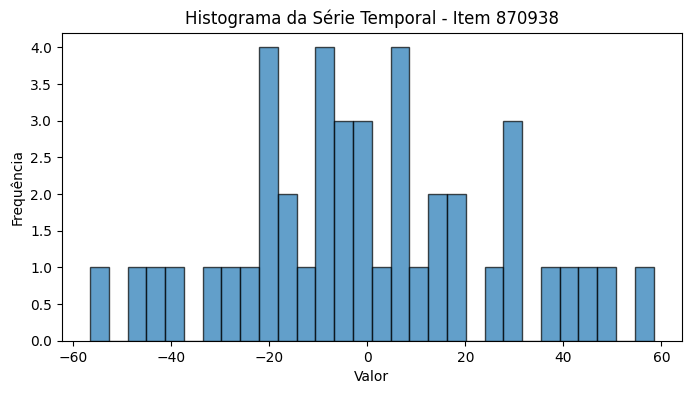

In [72]:
plt.figure(figsize=(8, 4))
plt.hist(residuos_item, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma da Série Temporal - Item ' + str(item_nbr))
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

In [73]:
# Realizar o teste de Shapiro-Wilk
stat, p = shapiro(residuos_item)

# Exibir a estatística de teste e o valor p
print("Estatística de Teste:", stat)
print("Valor p:", p)

if p < 0.05:
  print("A distribuição não é normal (rejeita-se a hipótese nula).")
else:
  print("A distribuição é normal (aceita-se a hipótese nula).")

Estatística de Teste: 0.9901243828687453
Valor p: 0.969265560162455
A distribuição é normal (aceita-se a hipótese nula).
